<a href="https://colab.research.google.com/github/TakuInada/umcuEpi_longterm_ieeg_respect_bids/blob/master/time_resolvedPAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time-resolved PAC

number of times 5120


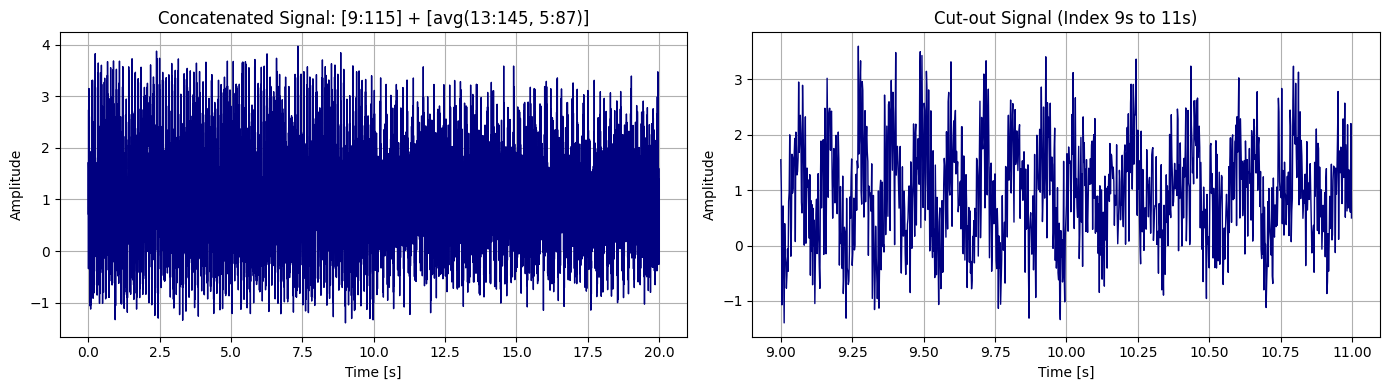

In [41]:
# Artificial signal
import numpy as np
import matplotlib.pyplot as plt
!pip install tensorpac
from tensorpac import Pac
from tensorpac.utils import PSD
from tensorpac.signals import pac_signals_tort

# Sampling settings
sf = 512          # Sampling rate
duration = 10      # Seconds
n_epochs = 20     # Number of Epochs
n_times = int(duration * sf)
print("number of times", n_times)

# SNR代替: noiseの強さ（小さいほどSNR高）
snr_noise = 2
pac_strength = 0.4
dpha = 70
damp = 20 # 位相・振幅の変動幅 → 広げるとピークがぼやける

# 3つのPACモードの合成信号を生成
signal1, time = pac_signals_tort(f_pha=[6, 12], f_amp=[100, 130], chi=pac_strength,
                                 noise=snr_noise, dpha=dpha, damp=damp, sf=sf,
                                 n_times=n_times, n_epochs=n_epochs)

signal2a, _ = pac_signals_tort(f_pha=13, f_amp=145, chi=pac_strength,
                              noise=snr_noise, dpha=dpha, damp=damp, sf=sf,
                               n_times=n_times, n_epochs=n_epochs)

signal2b, _ = pac_signals_tort(f_pha=5, f_amp=87, chi=pac_strength,
                              noise=snr_noise, dpha=dpha, damp=damp, sf=sf,
                               n_times=n_times, n_epochs=n_epochs)

# 合成（平均 or 単純和）して時系列として「signal1」と「combined_signal2」を縦に繋
combined_signal2 = (signal2a[0] + signal2b[0]) / 2
stacked_signal = np.concatenate([signal1[0], combined_signal2])
stacked_time = np.arange(0, stacked_signal.size) / sf

# 可視化
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(stacked_time, stacked_signal, lw=1, color='navy')
plt.title('Concatenated Signal: [9:115] + [avg(13:145, 5:87)]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

# Cut out the data from index 9 to 11 (inclusive)
cut_time = stacked_time[9*sf:11*sf]  # Indices 9, 10, 11 are included
cut_signal = stacked_signal[9*sf:11*sf]

# Plot the cut-out data in the second subplot
plt.subplot(1, 2, 2)
plt.plot(cut_time, cut_signal, lw=1, color='navy')
plt.title('Cut-out Signal (Index 9s to 11s)')  # Updated title
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

Compute PSD over 1 trials and 10240 time points
INFO:tensorpac:Compute PSD over 1 trials and 10240 time points
    Add 95th confidence interval
INFO:tensorpac:    Add 95th confidence interval
<ipython-input-43-6ab17a38228e>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  psd.plot(confidence=95, f_min=1, f_max=180, log=False, grid=True, fz_title=12, fz_labels=10)


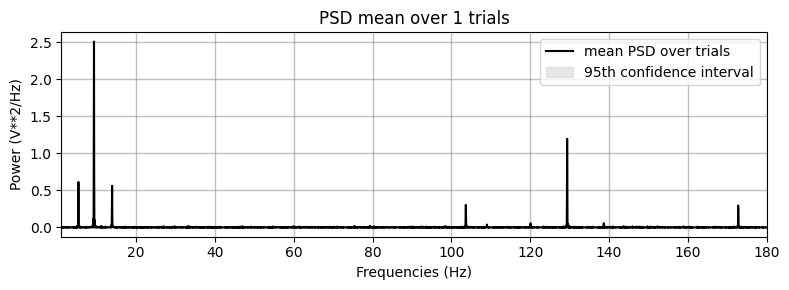

In [43]:
data = stacked_signal.reshape(1, -1) # reshape to (1, n_times)
psd = PSD(data, sf)

plt.figure(figsize=(8, 3))
# The 'basex' argument is deprecated
psd.plot(confidence=95, f_min=1, f_max=180, log=False, grid=True, fz_title=12, fz_labels=10)
plt.tight_layout()

Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined


PAC method:  Gaussian Copula PAC (gcPac)
Surrogates: Swap amplitude time blocks (Bahramisharif et al. 2013)
Normalization: Substract the mean of surrogates


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

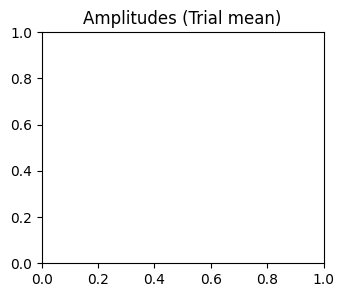

In [44]:
# Define a Pac object
p = Pac(idpac=(6, 2, 1), f_pha='hres', f_amp='hres')

print("PAC method: ", p.method)
print("Surrogates:", p.str_surro)
print("Normalization:", p.str_norm)
# extract all of the phases and amplitudes
phases = p.filter(sf, data, ftype='phase', n_jobs=1)
amplitudes = p.filter(sf, data, ftype='amplitude', n_jobs=1)
f_amp, f_pha = np.mean(p.f_amp, 1), np.mean(p.f_pha, 1)

plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.title("Amplitudes (Trial mean)")
plt.imshow(np.mean(amplitudes, 1)[::-1], cmap="turbo", extent=(0,stacked_time,f_amp[0],f_amp[-1]), aspect='auto')
plt.xlabel("Time (sec)"); plt.ylabel('Frequency for amplitude (hz)')

plt.subplot(1,2,2)
plt.title("Phases (Trial mean)")
plt.imshow(np.mean(phases, 1)[::-1], cmap="turbo", extent=(0,stacked_time,f_pha[0],f_pha[-1]), aspect='auto')
plt.xlabel("Time (sec)"); plt.ylabel('Frequency for phase (hz)')
plt.tight_layout()